# CT reconstruction via spectral decomposition of the atomic structure

First we load the atomic structure and the MD trajectory in order to generate the synthetic dataset.
For the atomic model in each frame we select the C-$\alpha$ positions.

In [1]:
import torch
import numpy as np
import mdtraj as md

## We load an MD trajectory.
## The molecular structure must be in a pdb or psf file.
## The trajectory is stored in a dcd file.

struct = 1 # 1 for the small protein (214 C-alpha atoms) and 2 for the big one (590 C-alpha atoms).

if struct == 1:
    MD_traj = md.load('data/struct1/dims0001_fit-core.dcd',top = 'data/struct1/adk4ake.psf')
if struct == 2:
    MD_traj = md.load('data/struct2/MD_traj2_short.dcd',top = 'data/struct2/DESRES-Trajectory_sarscov2-12212688-5-2-no-water.pdb')


## Here we select the C-alpha positions
indices = []
for m in MD_traj.topology.atoms_by_name('CA'):
    indices.append(m.index)

# We have to multily the trajectory by 10 so that the interatomic distance is in Angstroms
CA_pos = torch.tensor(MD_traj.xyz[:,indices,:])*10 
print('Average interatomic distance:',round(float((CA_pos[:,1:]-CA_pos[:,:-1]).norm(dim=-1).mean()),2), 'Angstroms')

Average interatomic distance: 3.84 Angstroms


## Parameters of the MD trajectory

Now we compute the parameters of each atomic model in the MD trajectory (rotation angles, orientation and location).
This will serve as ground truth.

In [2]:
## We set the reference atom. In this case, we select the atom which is most
# centred in the structure.

D = torch.zeros(CA_pos.shape[1])

for i in range(CA_pos.shape[1]):
    D[i] = (CA_pos[0] - CA_pos[0,i]).sum(dim=0).norm()

ref_idx = torch.argmin(D)

## We now compute the parameters for each of the chains in the MD trajectory
## These parameters represent the groud truth.

from tools.DFF import compute_parameters

Psi, Theta, x0s, Orientations, Dists = compute_parameters(CA_pos, ref_idx)

from data_generator.structure_batch import chain_structure

# We create a chain structure for the MD trajectory. This one will be used to generate the synthetic dataset.
trajectory_ground_truth = chain_structure(Psi, Theta, x0s, Orientations, Dists, ref_idx)

## We select the indexes that are to be estimated (those which may vary depending on the conformation).
## Since we do not have prior information about secondary structures, we select all the angles.
idx_model = list(range(Psi.shape[1]))

### Synthetic cryo-EM data

We generate the synthetic cryo-EM dataset. We need to specify the features of the dataset such as the CTF parameters and noise levels.

For each cryo-EM image, the defocus of the CTF is chosen at random among the values in the vector 'Df'.

$$
CTF(k, \lambda, \Delta f, C_s) = \left( \sqrt{1-\alpha^2}  \cos( \theta (k) ) - \alpha \sin( \theta (k) )   \right) \exp \left(-\frac{B|k|}{4} \right) 
$$
with
$$
\theta (k) :=2\pi \left( - \dfrac{\Delta f \lambda |k|^2}{2} + \dfrac{C_s \lambda^3 |k|^4}{4} \right) + \theta_0
\quad \text{for} \ k \in \left\{ \left(\frac{i}{2L},\frac{j}{2L}\right), \quad (i,j) \in [-n_{px}, \ldots , n_{px}-1]^2  \right\} 
$$
where $\Delta f$ is the defocus in Angstroms, e.g. $2.5\cdot 10^4$, $L$ is the length of the image side in Angstroms and $n_{px}$ is the number of pixels of the image side.

The wavelength $\lambda$ in terms of the voltage $V$ in KeV:
$$
\lambda = \dfrac{h}{\sqrt{2 m_0 E \left( 1+ \frac{E}{2m_0 c^2}\right)}} = \dfrac{12.2643247}{\sqrt{V\cdot 10^3 + 0.978466V^2}}.
$$ 

/home/ce423/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 400/400 [00:01<00:00, 377.75it/s]


Pixel size: 1.26


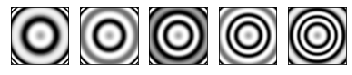

In [3]:
### Here we generate the dataset

from data_generator.dataset import dataset

CTF_data_feat = {
        'kV' : 200, # voltage in KV
        'Df' : torch.tensor([1.5, 1.75, 2., 2.25, 2.5]), # List of Defocus values in microns
        'Cs' : 2., # Spherical aberration in milimeters
        'alpha' : .1, # amplitude constrast 
        'B_factor' : 0., # Decay factor in Angstroms
        'phase_shift': 0. # Degrees
        }

dataset_features = {
        'struct' : trajectory_ground_truth,
        'n_imgs' : 400,
        'orient_variability' : torch.Tensor([[0,2*np.pi], 
                                             [0,2*np.pi], 
                                             [0,2*np.pi]]),
        'n_px_3d' : 16,
        'sigma_gaussian_3d' : 3.,
        'mask_size_3d' : 5, # voxels
        'noise_3d' : .5,
        
        'n_px_2d' : 64,
        'noise_2d' : 3.,
        'density_type': 'Gaussian',
        'sigma_density' : 3.,
        
        'CTF_data_feat' : CTF_data_feat
        }


(vols_data, structure_data, orientation_diffs_data, 
 CT_images_noise, CT_images_clean, clean_imgs_no_CTF, 
 img_lims, Df) = dataset(dataset_features)

# Let's display the CTF filters
from tools.CTF import CTF_filters

img_side = img_lims[0]-img_lims[1]

print('Pixel size:', round(float(img_side/dataset_features['n_px_2d']), 2))

filters = CTF_filters(dataset_features['n_px_2d'], img_side, CTF_data_feat['kV'], CTF_data_feat['Df'], CTF_data_feat['Cs'], 
                      CTF_data_feat['alpha'], CTF_data_feat['B_factor'], CTF_data_feat['phase_shift'])

from tools.plots import disp_image
disp_image(filters, multi_img = True)


### Examples of synthetic cryo-EM images

First row after applying the X-ray transform to the particle.
Second row after convolving with the CTF
Third row after adding gaussian noise

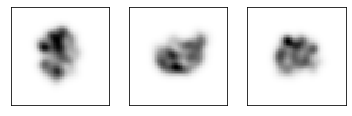

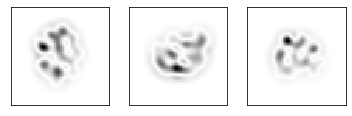

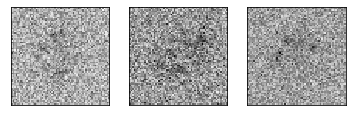

Signal to noise ratio: 0.0578


In [4]:
# Let's display some images
imgs = clean_imgs_no_CTF[:3]
disp_image(imgs, multi_img = True)

imgs = CT_images_clean[:3]
disp_image(imgs, multi_img = True)

imgs = CT_images_noise[:3]
disp_image(imgs, multi_img = True)


## Signal to Noise Ratio (SNR)
print('Signal to noise ratio:', round(float(CT_images_clean.var()/dataset_features['noise_2d']**2), 4))

## Construct the model

Here we construct the model to make the predictions. We need to select the given conformation, which will be used as initialization, the number of eigenvectors in the spectral decomposition. We also need to specify the features of the images such as dimensions and CTF parameters.

In [5]:
# As given conformation we take the first structure in the MD trajectory
n_init = 0 
Psi_init = trajectory_ground_truth.Psi[n_init]
Theta_init = trajectory_ground_truth.Theta[n_init]
ref_idx = trajectory_ground_truth.ref_idx

# The interatomic distance is set to be constant 
# and equal to the average interatomic distance
# in the given conformation.
dists = trajectory_ground_truth.dists[n_init]
dists = dists*0 + dists.mean()

# We specify the number of eigenvectors for the spectral decomposition.
n_eigenval = 10

model_features = {
        'n_eigenval' : n_eigenval,
        
        # Given atomic model
        'Psi_init' : Psi_init,
        'Theta_init' : Theta_init,
        'dists' : dists,
        'ref_idx': ref_idx,
        
        # Features of the images
        'img_lims': img_lims, 
        'n_px': CT_images_noise.shape[-1],
        'sigma_density' : dataset_features['sigma_density'], # sigma of the Gaussian density for each atom
        'density_type' : dataset_features['density_type'],        
        'CTF_feat' : CTF_data_feat,
        
        # List of indexes to be estimated
        'param_idxs' : idx_model
        
        }

from model.model_chain import model_chain

model = model_chain(model_features)

## Graph Laplacian

Time to compute the graph Laplacian: 0.07532238960266113
Time to compute the eigenvectors: 0.11251974105834961


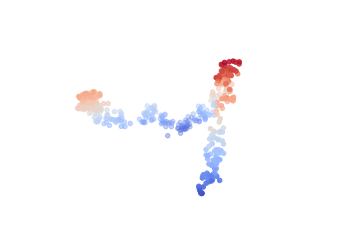

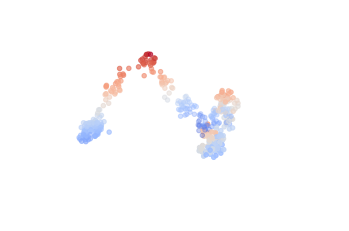

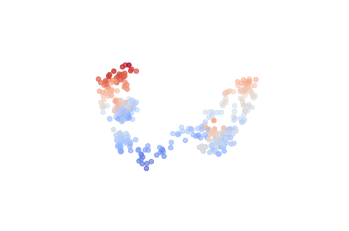

In [6]:
from time import time
from tools.graph import graph_gaussian_kernel, laplacian, eigen_graph

sigma_gauss_kernel = 5*dataset_features['n_px_3d']*dataset_features['noise_3d']

start = time()
graph = graph_gaussian_kernel(vols_data, sigma_gauss_kernel).detach()
print('Time to compute the graph Laplacian:', time() - start)

start = time()
Lap = laplacian(graph, True)
[eigen_val, eigen_vec] = eigen_graph(Lap, n_eigenval)
print('Time to compute the eigenvectors:', time() - start)

from tools.plots import disp_point_cloud

disp_point_cloud(eigen_vec[:, [1,2,3]])
disp_point_cloud(eigen_vec[:, [1,2,4]])
disp_point_cloud(eigen_vec[:, [1,3,4]])

## Training and test data

Here we split the cryo-EM dataset into training and test data,

In [7]:
from tools.training import Dataset, train_model

# The orientation of the particles in the images are the sum of the 
# orientation of the particle in the MD trajectory plus the rotation
# applied when generating the cryo-EM dataset.
# This information is assumed to be known.

orientations = structure_data.orientation + orientation_diffs_data

# The inputs for the model are the following, which we concatenate in a single tensor: 
# -the eigenvector coordinates of each particle
# -the orientation of each particle
# -the location of each particle
# -the defocus of each image
inputs = torch.cat([eigen_vec, orientations, structure_data.x0, Df.unsqueeze(-1)], dim = -1)


train_pctg = .9
n_total = inputs.shape[0]
n_train = int(train_pctg*n_total)
n_test = n_total - n_train 
train_idx, test_idx = torch.utils.data.random_split(range(n_total), [n_train, n_test])

# Here we select the training data, i.e. the cryo-EM images with the corresponding inputs
train_inputs = inputs[train_idx]
training_data = Dataset(train_inputs, CT_images_noise[train_idx])


# Here we select the test data, i.e. the cryo-EM images with the corresponding inputs
# We also compute the atomic model for each particle, that are used to evaluate the accuracy of the predictions.
struct_ground_truth_test = structure_data.discrete_curves(orientation_diffs_data)[test_idx]
test_inputs = inputs[test_idx]

test_data_pointcloud = Dataset(test_inputs, struct_ground_truth_test)
test_data = Dataset(test_inputs, CT_images_clean[test_idx])


# Here we compute the CT images (without CTF) and the atomic models before training the model
# These will be used at the end to compare with the predictions after training.
preds_init_imgs = model.pred_images_without_CTF(test_inputs[:20, :-1]).detach()
struct_init = model.forward_disc_curve(test_inputs[:20]).detach()

###  Apply SGD to estimate the coefficients

This make take several minutes.

Initial test loss: 0.34663850360586884
Initial test average point cloud error: 6.385672569274902
Initial test average max point cloud error: 19.100357055664062
Initial test max point cloud error: 28.280302047729492


  0%|          | 0/4 [00:00<?, ?it/s]/home/ce423/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 1 completed.
Training loss: 9.382407219041278
Test loss: 0.3386801142917769
Test average point cloud error: 6.224964618682861
Test average max point cloud error: 18.831567764282227
Test  max point cloud error: 27.858850479125977


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 2 completed.
Training loss: 9.368453140391416
Test loss: 0.3229845084093669
Test average point cloud error: 5.889713764190674
Test average max point cloud error: 18.27220344543457
Test  max point cloud error: 26.939586639404297


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 3 completed.
Training loss: 9.349106156877598
Test loss: 0.3061869371761444
Test average point cloud error: 5.533676624298096
Test average max point cloud error: 17.62725830078125
Test  max point cloud error: 25.86097526550293


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Epoch 4 completed.
Training loss: 9.3303915945465
Test loss: 0.2921983256344802
Test average point cloud error: 5.253328323364258
Test average max point cloud error: 16.989612579345703
Test  max point cloud error: 24.860820770263672


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 5 completed.
Training loss: 9.313102752807024
Test loss: 0.2840048085535219
Test average point cloud error: 5.089756011962891
Test average max point cloud error: 16.33597755432129
Test  max point cloud error: 24.013887405395508


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Epoch 6 completed.
Training loss: 9.301895478531485
Test loss: 0.2824068396780408
Test average point cloud error: 5.011107444763184
Test average max point cloud error: 15.68353271484375
Test  max point cloud error: 23.25021743774414


100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 7 completed.
Training loss: 9.2923576855366
Test loss: 0.279980171001237
Test average point cloud error: 4.938031196594238
Test average max point cloud error: 15.087246894836426
Test  max point cloud error: 22.717737197875977


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 8 completed.
Training loss: 9.285874590103113
Test loss: 0.27708283825062463
Test average point cloud error: 4.871315956115723
Test average max point cloud error: 14.54096794128418
Test  max point cloud error: 22.281221389770508


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 9 completed.
Training loss: 9.278578194543634
Test loss: 0.27392395719255014
Test average point cloud error: 4.805708885192871
Test average max point cloud error: 14.104375839233398
Test  max point cloud error: 21.78788185119629


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 10 completed.
Training loss: 9.271450367697788
Test loss: 0.2705226154710077
Test average point cloud error: 4.728682518005371
Test average max point cloud error: 13.7552490234375
Test  max point cloud error: 21.320402145385742


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 11 completed.
Training loss: 9.265787439999405
Test loss: 0.26732391012802925
Test average point cloud error: 4.641175746917725
Test average max point cloud error: 13.416356086730957
Test  max point cloud error: 20.702960968017578


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 12 completed.
Training loss: 9.260341998394514
Test loss: 0.2644505141024665
Test average point cloud error: 4.547688007354736
Test average max point cloud error: 13.119359970092773
Test  max point cloud error: 20.178363800048828


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 13 completed.
Training loss: 9.25408670287644
Test loss: 0.26094538853534094
Test average point cloud error: 4.46561336517334
Test average max point cloud error: 12.86542797088623
Test  max point cloud error: 19.649303436279297


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Epoch 14 completed.
Training loss: 9.248852809512018
Test loss: 0.25615700287616755
Test average point cloud error: 4.391693592071533
Test average max point cloud error: 12.652519226074219
Test  max point cloud error: 19.495506286621094


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 15 completed.
Training loss: 9.242575384655401
Test loss: 0.2509778079026739
Test average point cloud error: 4.312526702880859
Test average max point cloud error: 12.43403434753418
Test  max point cloud error: 19.446435928344727


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Epoch 16 completed.
Training loss: 9.23943909149896
Test loss: 0.24629759078049998
Test average point cloud error: 4.233541965484619
Test average max point cloud error: 12.268609046936035
Test  max point cloud error: 19.381805419921875


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Epoch 17 completed.
Training loss: 9.234039314955547
Test loss: 0.24163283722026221
Test average point cloud error: 4.173776626586914
Test average max point cloud error: 12.126371383666992
Test  max point cloud error: 19.322669982910156


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Epoch 18 completed.
Training loss: 9.229423243644142
Test loss: 0.23804034526301238
Test average point cloud error: 4.120030403137207
Test average max point cloud error: 11.98250961303711
Test  max point cloud error: 19.20549964904785


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Epoch 19 completed.
Training loss: 9.226521965887564
Test loss: 0.23541253804421283
Test average point cloud error: 4.068131923675537
Test average max point cloud error: 11.849710464477539
Test  max point cloud error: 19.110076904296875


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Epoch 20 completed.
Training loss: 9.222096573069853
Test loss: 0.23265229665813517
Test average point cloud error: 4.021925449371338
Test average max point cloud error: 11.694374084472656
Test  max point cloud error: 19.013534545898438


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Epoch 21 completed.
Training loss: 9.218831656421571
Test loss: 0.2296498440430915
Test average point cloud error: 3.9720091819763184
Test average max point cloud error: 11.540392875671387
Test  max point cloud error: 18.871809005737305


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 22 completed.
Training loss: 9.213561173590158
Test loss: 0.22677485024045252
Test average point cloud error: 3.9156148433685303
Test average max point cloud error: 11.384963989257812
Test  max point cloud error: 18.72990608215332


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 23 completed.
Training loss: 9.210396658097292
Test loss: 0.22298887813714163
Test average point cloud error: 3.860936164855957
Test average max point cloud error: 11.228899955749512
Test  max point cloud error: 18.60256004333496


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Epoch 24 completed.
Training loss: 9.207430029591356
Test loss: 0.21932386756438732
Test average point cloud error: 3.80672550201416
Test average max point cloud error: 11.068197250366211
Test  max point cloud error: 18.4554443359375


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Epoch 25 completed.
Training loss: 9.203844814421673
Test loss: 0.21606226263892075
Test average point cloud error: 3.757030487060547
Test average max point cloud error: 10.935050964355469
Test  max point cloud error: 18.319541931152344


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Epoch 26 completed.
Training loss: 9.200306946721074
Test loss: 0.21441471768872788
Test average point cloud error: 3.7208969593048096
Test average max point cloud error: 10.812544822692871
Test  max point cloud error: 18.21063995361328


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Epoch 27 completed.
Training loss: 9.198539925846305
Test loss: 0.21147377499010678
Test average point cloud error: 3.6835782527923584
Test average max point cloud error: 10.680896759033203
Test  max point cloud error: 18.068557739257812


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 28 completed.
Training loss: 9.195962958141093
Test loss: 0.2092520496669205
Test average point cloud error: 3.6454479694366455
Test average max point cloud error: 10.588096618652344
Test  max point cloud error: 17.911273956298828


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 29 completed.
Training loss: 9.19176153321047
Test loss: 0.2072599419262923
Test average point cloud error: 3.604478597640991
Test average max point cloud error: 10.503511428833008
Test  max point cloud error: 17.730262756347656


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 30 completed.
Training loss: 9.18950693917231
Test loss: 0.20464059148703045
Test average point cloud error: 3.55967116355896
Test average max point cloud error: 10.413688659667969
Test  max point cloud error: 17.56642723083496
Training finished. Elapsed time: 122.92413544654846


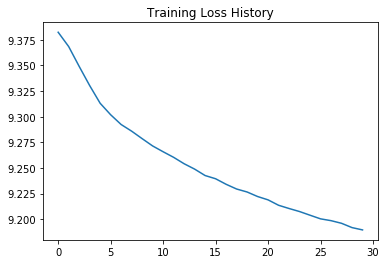

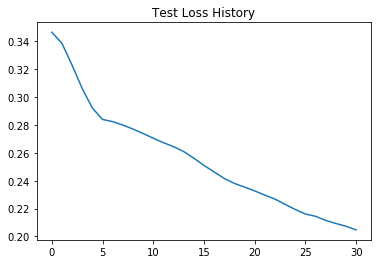

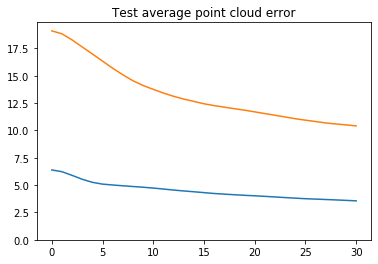

Training finished. Elapsed time: 123.18527126312256
Training loss: 9.18950693917231
Test loss: 0.20464059148703045
Test average point cloud error: 3.55967116355896
Test average max point cloud error: 10.413688659667969
Test  max point cloud error: 17.56642723083496


In [8]:
### Training

# Generators
training_params = {'batch_size': 100,
          'shuffle': True,
          'max_epochs' : 30,
          'learning_rate' : .1,
          'momentum': .9}

train_model(model, training_data, test_data, test_data_pointcloud, training_params)

## Display some predictions

We compare the initial guess for the particle with the ground truth and the prediction after the optimization.

Here we show the tomographic projection of the particles (without the CTF).

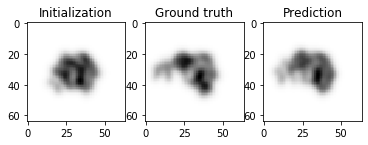

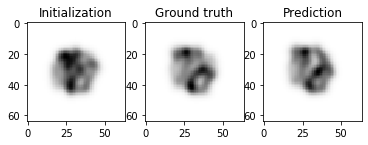

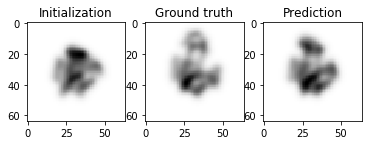

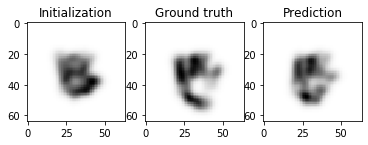

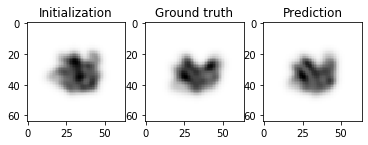

In [9]:
# Let's compare the tomographic projections of the predicted structures 
# with the ground truth and the initialization.
from tools.plots import disp_img_validation

preds_imgs = model.pred_images_without_CTF(test_inputs[:5, :-1]).detach()

original_imgs = clean_imgs_no_CTF[test_idx]

disp_img_validation(preds_init_imgs, original_imgs, preds_imgs)

#### Predictions of the atomic structures

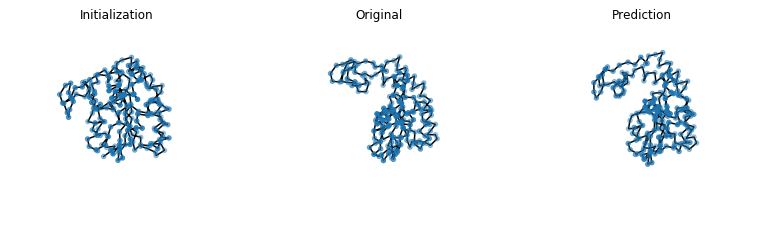

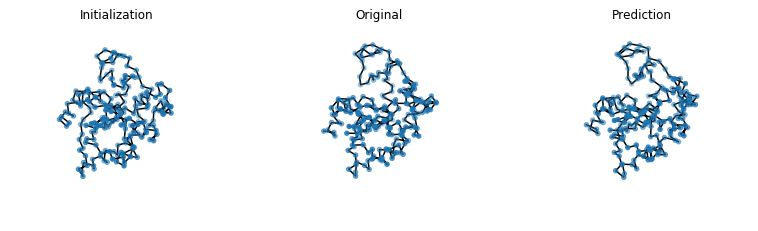

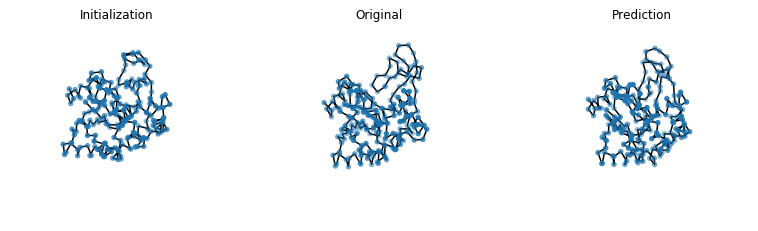

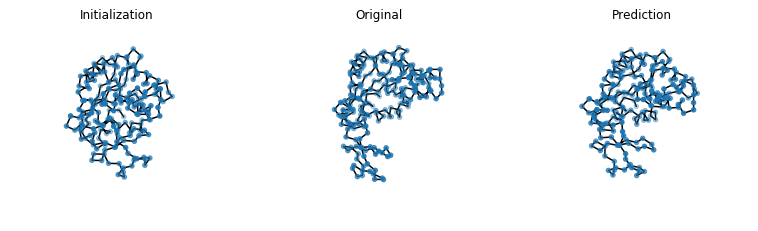

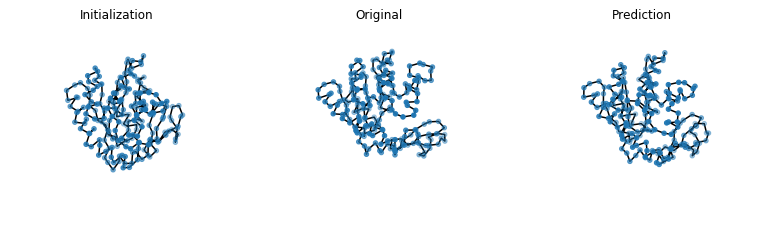

In [10]:
# Let's compare the predicted structures 
# with the ground truth and the initialization.

from tools.plots import disp_struct_validation

struct_preds = model.forward_disc_curve(test_inputs[:5]).detach()

struct_ground_truth = structure_data.discrete_curves(orientation_diffs_data).detach()[test_idx][:5]

disp_struct_validation(struct_init, struct_ground_truth, struct_preds)